<a href="https://colab.research.google.com/github/RumeysaCeylan/ImageClassification/blob/main/densenet169_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
#IMPORT / VIEWING / PREPROCESSING DATASET

In [ ]:
#DATA AUGMENTATION

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/Train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 19175 images belonging to 4 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/Validation',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 799 images belonging to 4 classes.


100%|██████████| 5/5 [00:19<00:00,  3.80s/it]


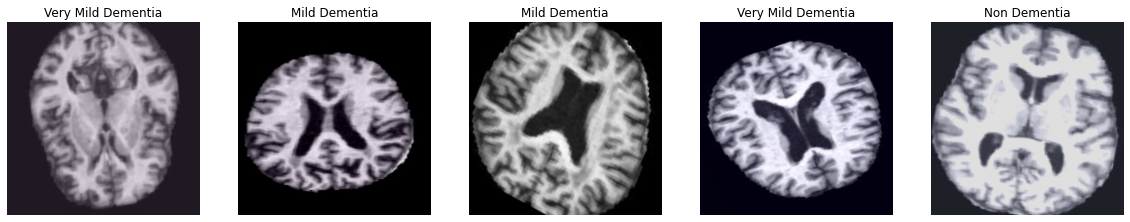

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Dementia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [ ]:
#MODEL BUILDING

In [ ]:
base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 0s 0us/step


In [ ]:

# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [ ]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [ ]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
import tensorflow as tf

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics = METRICS,
              optimizer=OPT)

In [ ]:
# Defining Callbacks

filepath = '/content/drive/MyDrive/Colab Notebooks/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/50
150/150 [==============================] - ETA: 0s - loss: 1.1490 - accuracy: 0.7798 - precision: 0.5719 - recall: 0.4740 - auc: 0.8050 - f1_score: 0.5178 
Epoch 1: val_auc improved from -inf to 0.91125, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
150/150 [==============================] - 5819s 39s/step - loss: 1.1490 - accuracy: 0.7798 - precision: 0.5719 - recall: 0.4740 - auc: 0.8050 - f1_score: 0.5178 - val_loss: 0.7104 - val_accuracy: 0.8473 - val_precision: 0.7283 - val_recall: 0.6208 - val_auc: 0.9112 - val_f1_score: 0.6700
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 0.8271 - accuracy: 0.8234 - precision: 0.6770 - recall: 0.5617 - auc: 0.8795 - f1_score: 0.6136
Epoch 2: val_auc improved from 0.91125 to 0.94504, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
150/150 [==============================] - 277s 2s/step - loss: 0.8271 - accuracy: 0.8234 - precision: 0.6770 - recall: 0.5617 - auc

In [ ]:
#MODEL EVALUATION

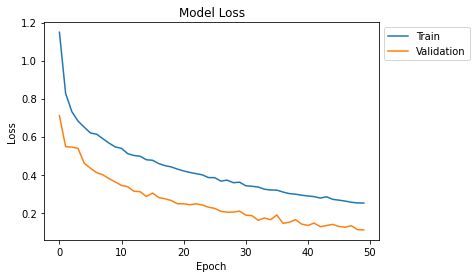

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

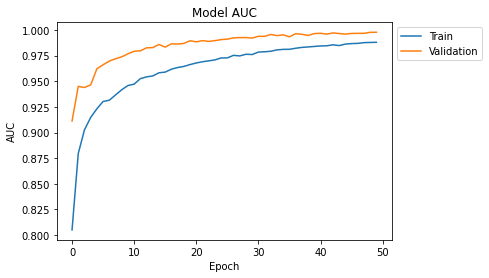

In [ ]:
# Summarize history for auc

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

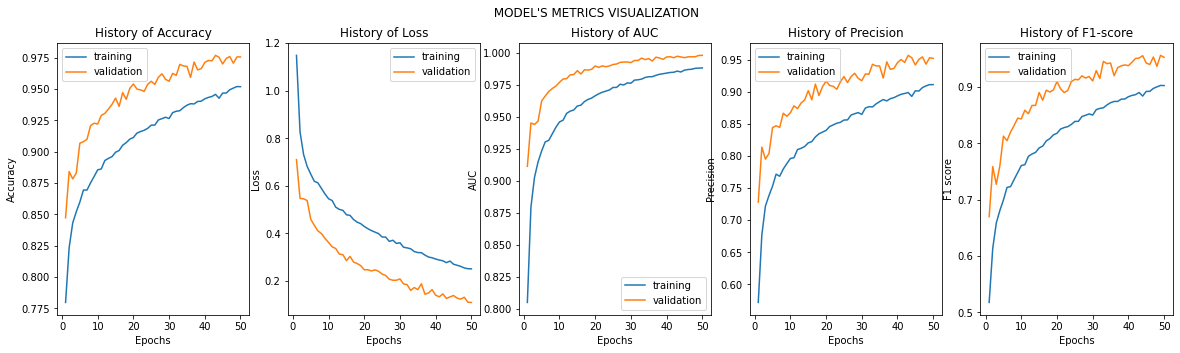

In [ ]:

#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision'],
               model_history.history['f1_score'],model_history.history['val_f1_score']
              )

In [6]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/dataset/Test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 2000 images belonging to 4 classes.


In [12]:
# Evaluating Loss and AUC

score=model.evaluate(test_dataset)


RuntimeError: ignored

In [ ]:
print("Loss = ",score[0])
print("Accuracy = ", score[1])
print("Precision = ", score[2])
print("Recall = ", score[3])
print("AUC = ", score[4])
print("F1_score = ", score[5])

Loss =  0.1415584236383438
Accuracy =  0.9728749990463257
Precision =  0.9477649331092834
Recall =  0.9434999823570251
AUC =  0.9956905245780945
F1_score =  0.9463099241256714


In [2]:
import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/best_weights.hdf5', compile = False)

In [ ]:
pred = model.predict(test_dataset, batch_size = 8)

150/150 [==============================] - 5677s 38s/step


In [ ]:
pred_final = np.where(pred>0.5,1,0)

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
 

y_preds=model.predict(test_dataset)

fpr,tpr,thresholds = roc_curve(score[1], score[2])
plt.figure(1)
plt.plot([0,1],[0,1],'y--')
plt.plot(fpr,tpr,marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

10/16 [=================>............] - ETA: 2:20

In [ ]:
"""
import seaborn as sn
pred = model.predict(test_dataset, batch_size=32, verbose=1)
predicted = np.argmax(pred, axis=1)

cm = confusion_matrix(np.argmax(test_dataset, axis=1), predicted)

# Visualizing of confusion matrix
crn50_df_cm = pd.DataFrame(cm, range(100), range(100))
plt.figure(figsize = (20,14))
sn.set(font_scale=1.4) #for label size
sn.heatmap(crn50_df_cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
"""

NameError: ignored

In [ ]:
"""
# Get the confusion matrix

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_preds, pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['0','1'], fontsize=10)
plt.yticks(range(2), ['0','1'], fontsize=10)
plt.show()
"""

ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

_,actual,_,_,_,_ = model.predict(test_dataset, batch_size = 8)
_,_,predicted,_,_,_  = model.predict(test_dataset, batch_size = 8)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

 1/16 [>.............................] - ETA: 7:06

1/1 [==============================] - 4s 4s/step
99.98 % chances are there that the image is NonDemented


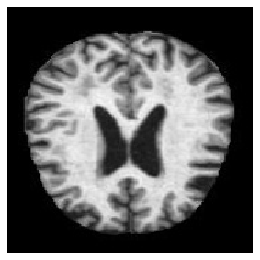

In [ ]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/00b8529f-23c6-415c-96cc-a4e6ca6ed6ac.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 45ms/step
99.91 % chances are there that the image is NonDemented


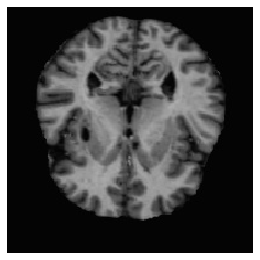

In [ ]:
# Test Case 1_1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/00e94d2d-4d78-43eb-933e-1c8cbfe974fd.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 47ms/step
99.96 % chances are there that the image is NonDemented


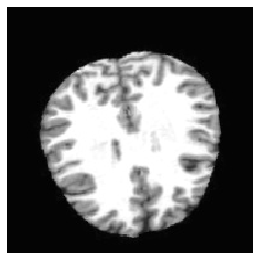

In [ ]:
# Test Case 1_2: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/01a1f60e-a95b-4f6b-b84a-d35c5b241bb1.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 46ms/step
99.39 % chances are there that the image is NonDemented


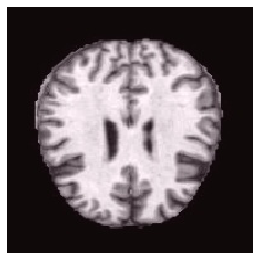

In [ ]:
# Test Case 1_3: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/0ab1d152-a70b-451a-9840-da1bb72e6b91.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 51ms/step
99.84 % chances are there that the image is NonDemented


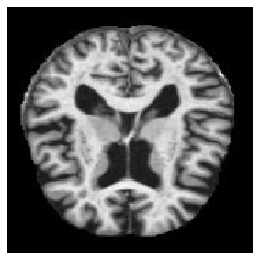

In [ ]:
# Test Case 1_4: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/dataset/Test/NonDemented/0b7e0c7c-eee7-49de-931c-cffaa8d1bbcc.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 45ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 41ms/step
99.98 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 32ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 35ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 31ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 104ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 33ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 32ms/step
100.0 % chances are there that the image is ModerateDemented
1/1 [==============================] - 0s 33ms/step
100.0 % chances are there that the image is

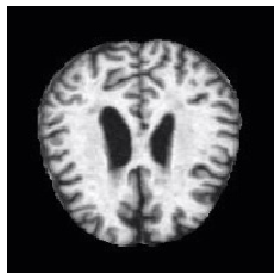

In [ ]:


import cv2
import glob 

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/ModerateDemented/*.jpg"):
  img = cv2.imread(img_x)
  img = load_img(img_x, target_size = (224,224,3))
  #img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/verymildDem430.jpg', target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  imshow(img)
  plt.axis('off')
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  print(probability, '% chances are there that the image is',idc[answer[0]])

In [ ]:
# MODERATE 

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/ModerateDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "ModerateDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 34ms/step
correct: 500
images: 500
percentage: 1.0


1/1 [==============================] - 0s 48ms/step
99.92 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 32ms/step
97.81 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 34ms/step
99.52 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 31ms/step
99.98 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 34ms/step
99.67 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 83ms/step
99.98 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 33ms/step
99.9 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 39ms/step
100.0 % chances are there that the image is MildDemented
1/1 [==============================] - 0s 34ms/step
99.9 % chances are there that the image is MildDemented
1/1 [================

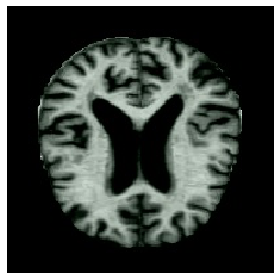

In [ ]:
dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/MildDemented/*.jpg"):
  img = cv2.imread(img_x)
  img = load_img(img_x, target_size = (224,224,3))
  #img = load_img('/content/drive/MyDrive/Colab Notebooks/archive_y/OriginalDataset/VeryMildDemented/verymildDem430.jpg', target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  imshow(img)
  plt.axis('off')
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  print(probability, '% chances are there that the image is',idc[answer[0]])

In [7]:
# MILD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/MildDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "MildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 359ms/step
correct: 492
images: 500
percentage: 0.984


In [8]:
# NON

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/NonDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "NonDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 301ms/step
correct: 475
images: 500
percentage: 0.95


In [9]:
# VERY MILD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/MildDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "MildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 380ms/step
correct: 492
images: 500
percentage: 0.984


In [10]:
# VERY MILD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/drive/MyDrive/dataset/Test/VeryMildDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "VeryMildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 332ms/step
correct: 424
images: 500
percentage: 0.848
